# Assignment 1

Deadline: 19.03.2025, 12:00 CET

Khoshimov Rakhmatillokhon 23-060-361 rakhmatillokhon.khoshimov@uzh.ch

In [1]:
# Import standard libraries
import os
import sys
import timeit
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Since the current directory is 'assignments', the project root is one level up.
project_root = os.path.dirname(os.getcwd())
# Add the project root to sys.path so that modules under 'src' are importable
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now import local modules using absolute paths (starting from 'src')
from src.estimation.covariance import Covariance, CovarianceSpecification
from src.estimation.expected_return import ExpectedReturn, ExpectedReturnSpecification
from src.optimization.constraints import Constraints
from src.optimization.optimization import Optimization, Objective, OptimizationParameter
from src.optimization.optimization_data import OptimizationData
from src.optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

print(f"Available solvers: {USABLE_SOLVERS}")

Available solvers: {'highs', 'daqp', 'quadprog', 'osqp', 'qpalm', 'cvxopt'}


## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [23]:
# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Set random seed for reproducibility
np.random.seed(42)

# 1. Generate mean returns between 1% and 5%
mean = np.random.uniform(0.01, 0.05, N)

# 2. Generate covariance matrix that is positive definite
# Create a random matrix A
A = np.random.randn(N, N)
# Create a positive definite matrix using A*A^T
cov = np.dot(A, A.T) 
# Scale down the values
cov = cov / (10 * N)
# Set reasonable diagonal elements (variance between 0.01 and 0.10)
np.fill_diagonal(cov, np.random.uniform(0.01, 0.10, N))

# 3. Generate the multivariate normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

# 4. Convert to DataFrame with column names
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# 5. Compute expected returns using the ExpectedReturn class
# Create the specification object
er_spec = ExpectedReturnSpecification(method='geometric', scalefactor=1)
# Create the estimator
er_estimator = ExpectedReturn(spec=er_spec)
# Estimate expected returns
er_estimator.estimate(X=df)
# Get the vector of expected returns
q = er_estimator.vector

# 6. Compute covariance matrix using the Covariance class
# Create the specification object
cov_spec = CovarianceSpecification(method='pearson')
# Create the estimator
cov_estimator = Covariance(spec=cov_spec)
# Estimate covariance matrix
cov_estimator.estimate(X=df)
# Get the covariance matrix
P = cov_estimator.matrix

# 7. Display results
print("Vector of expected returns (q):")
print(q.head())  # Show just first 5 values

print("\nCovariance matrix shape:")
print(P.shape)

print("\nSample of covariance matrix (first 5x5):")
print(P.iloc[:5, :5])

Vector of expected returns (q):
Asset_1   -0.018563
Asset_2    0.007417
Asset_3    0.009917
Asset_4   -0.011868
Asset_5   -0.036937
dtype: float64

Covariance matrix shape:
(100, 100)

Sample of covariance matrix (first 5x5):
          Asset_1   Asset_2   Asset_3   Asset_4   Asset_5
Asset_1  0.070622  0.001024 -0.000161  0.009742 -0.015690
Asset_2  0.001024  0.076968 -0.001969 -0.003555  0.002034
Asset_3 -0.000161 -0.001969  0.050526  0.004850  0.002349
Asset_4  0.009742 -0.003555  0.004850  0.080594  0.004375
Asset_5 -0.015690  0.002034  0.002349  0.004375  0.075049


/var/folders/b6/r9gq_shd5r1cg8x06t586cf00000gn/T/ipykernel_45176/2462111728.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, size=T)
/Users/rakhmatillokhonkhoshimov/qpmwp-course/env3.12/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [24]:
# 1. Instantiate the Constraints class with asset IDs
constraints = Constraints(ids=df.columns.tolist())

# 2. Add budget constraint (weights sum to 1)
constraints.add_budget(rhs=1, sense='=')

# 3. Add box constraints (0.0 ≤ weights ≤ 0.2)
constraints.add_box(box_type="LongOnly", lower=0.0, upper=0.2)

# 4. Add group constraints
# Group 1: First 30 assets sum ≤ 0.3
g1_values = pd.Series(0, index=df.columns)
g1_values.iloc[:30] = 1
constraints.add_linear(g_values=g1_values, sense='<=', rhs=0.3, name='group1')

# Group 2: Assets 31-60 sum ≤ 0.4
g2_values = pd.Series(0, index=df.columns)
g2_values.iloc[30:60] = 1
constraints.add_linear(g_values=g2_values, sense='<=', rhs=0.4, name='group2')

# Group 3: Assets 61-100 sum ≤ 0.5
g3_values = pd.Series(0, index=df.columns)
g3_values.iloc[60:] = 1
constraints.add_linear(g_values=g3_values, sense='<=', rhs=0.5, name='group3')

# 5. Display constraints summary
print("Budget constraint:")
print(f"- Asset weights sum to {constraints.budget['rhs']}")

print("\nBox constraints:")
print(f"- Type: {constraints.box['box_type']}")
print(f"- Lower bounds: {constraints.box['lower'].iloc[0]:.1f} for all assets")
print(f"- Upper bounds: {constraints.box['upper'].iloc[0]:.1f} for all assets")

print("\nGroup constraints:")
print(f"- Group 1 (assets 1-30): Sum ≤ {0.3}")
print(f"- Group 2 (assets 31-60): Sum ≤ {0.4}")
print(f"- Group 3 (assets 61-100): Sum ≤ {0.5}")

# Return the constraints object
constraints

Budget constraint:
- Asset weights sum to 1

Box constraints:
- Type: LongOnly
- Lower bounds: 0.0 for all assets
- Upper bounds: 0.2 for all assets

Group constraints:
- Group 1 (assets 1-30): Sum ≤ 0.3
- Group 2 (assets 31-60): Sum ≤ 0.4
- Group 3 (assets 61-100): Sum ≤ 0.5


### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [25]:
# 1. Convert constraints to the format required by solvers
GhAb = constraints.to_GhAb()

# 2. Set up risk aversion parameter 
risk_aversion = 1.0

# 3. Prepare dataframe for storing results
results = {
    'solution_found': {},
    'objective': {},
    'primal_residual': {},
    'dual_residual': {},
    'duality_gap': {},
    'runtime': {}
}

# 4. Test all available solvers
for solver in USABLE_SOLVERS:
    print(f"\nTesting solver: {solver}")
    
    try:
        # Start timer
        start_time = timeit.default_timer()
        
        # Create the quadratic program
        qp = QuadraticProgram(
            P=P.to_numpy() * risk_aversion,  # Scale covariance by risk aversion
            q=-q.to_numpy(),                 # Negative for maximization
            G=GhAb['G'],
            h=GhAb['h'],
            A=GhAb['A'],
            b=GhAb['b'],
            lb=constraints.box['lower'].to_numpy(),
            ub=constraints.box['upper'].to_numpy(),
            solver=solver
        )
        
        # Solve the optimization problem
        qp.solve()
        
        # Calculate runtime
        runtime = timeit.default_timer() - start_time
        
        # Get solution
        solution = qp.results['solution']
        
        # Record results
        results['solution_found'][solver] = solution.found
        
        if solution.found:
            # Get objective value and metrics
            results['objective'][solver] = qp.objective_value(solution.x, constant=0)
            results['primal_residual'][solver] = solution.primal_residual
            results['dual_residual'][solver] = solution.dual_residual
            results['duality_gap'][solver] = solution.duality_gap
            
            print(f"  Solution found - Runtime: {runtime:.6f}s, Objective: {results['objective'][solver]:.6f}")
        else:
            # Set to NaN if no solution found
            results['objective'][solver] = np.nan
            results['primal_residual'][solver] = np.nan
            results['dual_residual'][solver] = np.nan
            results['duality_gap'][solver] = np.nan
            
            print(f"  No solution found - Runtime: {runtime:.6f}s")
        
        # Always record runtime
        results['runtime'][solver] = runtime
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        
        # Record failure
        results['solution_found'][solver] = False
        results['objective'][solver] = np.nan
        results['primal_residual'][solver] = np.nan
        results['dual_residual'][solver] = np.nan
        results['duality_gap'][solver] = np.nan
        results['runtime'][solver] = np.nan

# 5. Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nSolver Comparison Results:")
display(results_df.T)  # Transpose for better viewing


Testing solver: quadprog
  Solution found - Runtime: 0.011049s, Objective: -0.006867

Testing solver: osqp
  Solution found - Runtime: 0.245484s, Objective: -0.007113

Testing solver: qpalm
  Solution found - Runtime: 0.011859s, Objective: -0.006872

Testing solver: daqp
  Solution found - Runtime: 0.004449s, Objective: -0.006867

Testing solver: highs
  Solution found - Runtime: 0.026907s, Objective: -0.006867

Testing solver: cvxopt
  Solution found - Runtime: 0.726251s, Objective: -0.006867

Solver Comparison Results:


,quadprog,osqp,qpalm,daqp,highs,cvxopt
solution_found,True,True,True,True,True,True
objective,-0.006867,-0.007113,-0.006872,-0.006867,-0.006867,-0.006867
primal_residual,<bound method Solution.primal_residual of Solu...,<bound method Solution.primal_residual of Solu...,<bound method Solution.primal_residual of Solu...,<bound method Solution.primal_residual of Solu...,<bound method Solution.primal_residual of Solu...,<bound method Solution.primal_residual of Solu...
dual_residual,<bound method Solution.dual_residual of Soluti...,<bound method Solution.dual_residual of Soluti...,<bound method Solution.dual_residual of Soluti...,<bound method Solution.dual_residual of Soluti...,<bound method Solution.dual_residual of Soluti...,<bound method Solution.dual_residual of Soluti...
duality_gap,<bound method Solution.duality_gap of Solution...,<bound method Solution.duality_gap of Solution...,<bound method Solution.duality_gap of Solution...,<bound method Solution.duality_gap of Solution...,<bound method Solution.duality_gap of Solution...,<bound method Solution.duality_gap of Solution...
runtime,0.011049,0.245484,0.011859,0.004449,0.026907,0.726251


Print and visualize the results

Successful solvers: ['quadprog', 'osqp', 'qpalm', 'daqp', 'highs', 'cvxopt']


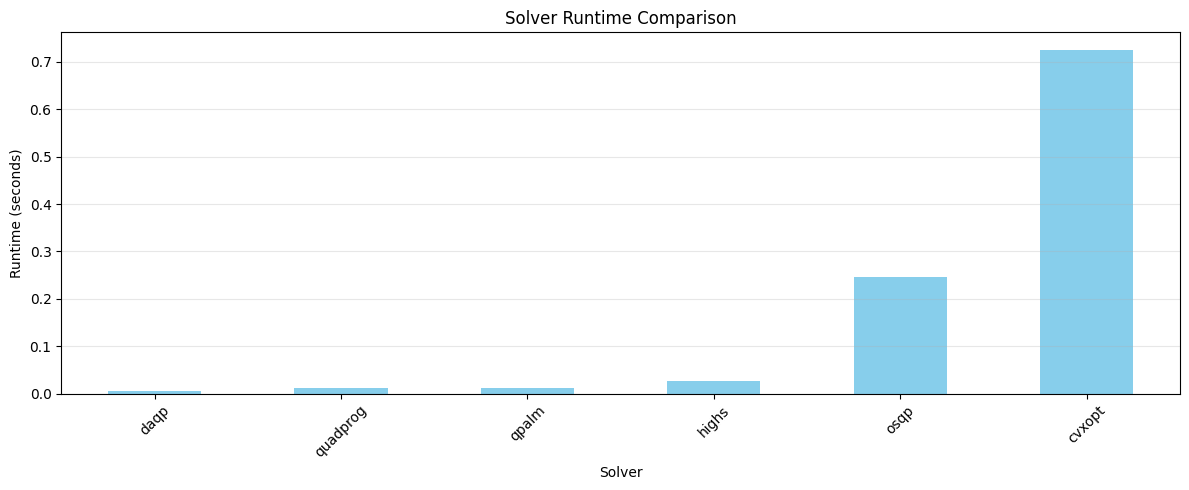

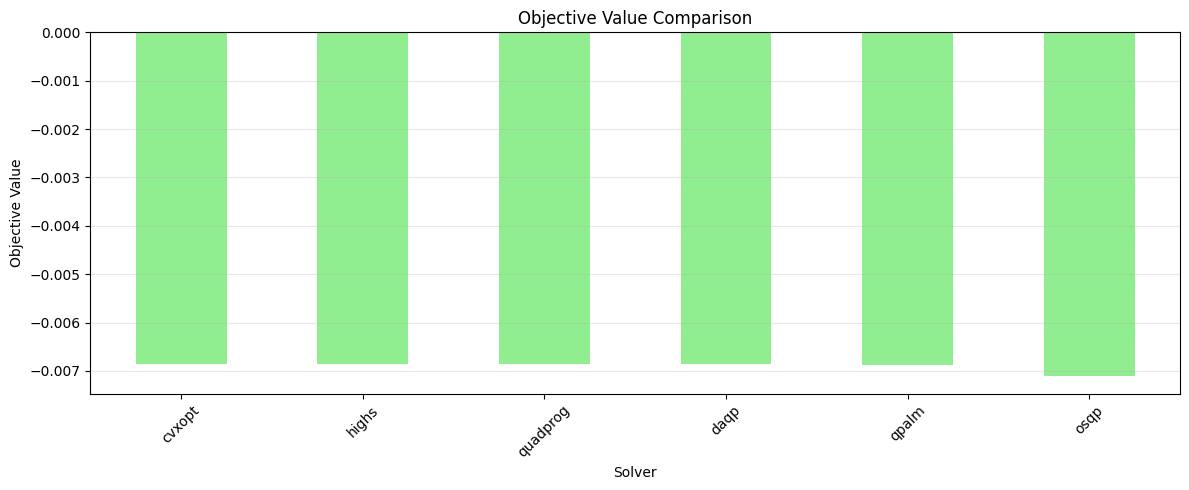

TypeError: '<' not supported between instances of 'method' and 'method'

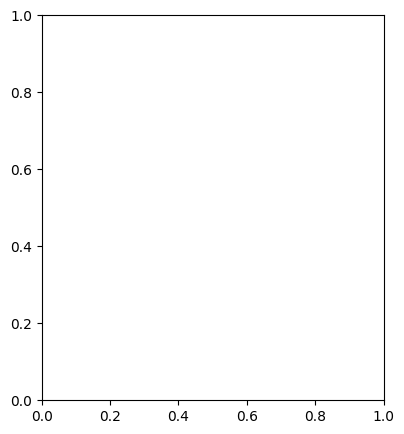

In [26]:
# 1. Filter out solvers that didn't find a solution
successful_solvers = results_df[results_df['solution_found'] == True].index
print(f"Successful solvers: {list(successful_solvers)}")

if len(successful_solvers) > 0:
    # 2. Runtime comparison
    plt.figure(figsize=(12, 5))
    runtime_data = results_df.loc[successful_solvers, 'runtime'].sort_values()
    runtime_data.plot(kind='bar', color='skyblue')
    plt.title('Solver Runtime Comparison')
    plt.xlabel('Solver')
    plt.ylabel('Runtime (seconds)')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Objective value comparison
    plt.figure(figsize=(12, 5))
    objective_data = results_df.loc[successful_solvers, 'objective'].sort_values(ascending=False)
    objective_data.plot(kind='bar', color='lightgreen')
    plt.title('Objective Value Comparison')
    plt.xlabel('Solver')
    plt.ylabel('Objective Value')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Reliability metrics comparison
    plt.figure(figsize=(15, 5))
    metrics = ['primal_residual', 'dual_residual', 'duality_gap']
    colors = ['coral', 'purple', 'gold']
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        metric_data = results_df.loc[successful_solvers, metric].sort_values()
        metric_data.plot(kind='bar', color=colors[i])
        plt.title(f'{metric.replace("_", " ").title()}')
        plt.xlabel('Solver')
        plt.ylabel('Value')
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Create a ranking table
    ranking_df = pd.DataFrame(index=successful_solvers)
    
    # Runtime rank (lower is better)
    ranking_df['Runtime Rank'] = results_df.loc[successful_solvers, 'runtime'].rank()
    
    # Objective rank (higher is better)
    ranking_df['Objective Rank'] = results_df.loc[successful_solvers, 'objective'].rank(ascending=False)
    
    # Reliability metrics ranks (lower is better)
    for metric in metrics:
        ranking_df[f'{metric.replace("_", " ").title()} Rank'] = results_df.loc[successful_solvers, metric].rank()
    
    # Calculate overall rank
    ranking_df['Overall Rank'] = ranking_df.mean(axis=1)
    
    # Sort by overall rank
    ranking_df = ranking_df.sort_values('Overall Rank')
    
    print("Solver Rankings (lower is better):")
    display(ranking_df)
    
    # 6. Store the best solver for part 2
    best_solver = ranking_df.index[0]
    print(f"\nBest solver: {best_solver}")
    
    # 7. Get the solution from the best solver
    best_qp = QuadraticProgram(
        P=P.to_numpy() * risk_aversion,
        q=-q.to_numpy(),
        G=GhAb['G'],
        h=GhAb['h'],
        A=GhAb['A'],
        b=GhAb['b'],
        lb=constraints.box['lower'].to_numpy(),
        ub=constraints.box['upper'].to_numpy(),
        solver=best_solver
    )
    best_qp.solve()
    best_solution = best_qp.results['solution']
    
    # Extract and store the weights for later comparison
    if best_solution.found:
        best_weights = pd.Series(best_solution.x, index=df.columns)
        
        plt.figure(figsize=(10, 5))
        best_weights.sort_values(ascending=False)[:20].plot(kind='bar', color='lightblue')
        plt.title(f'Top 20 Portfolio Weights using {best_solver}')
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No successful solvers to analyze")

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


1. Solving with analytical solution:
Analytical solution - first 10 weights:
Asset_1    -0.026348
Asset_2     0.012425
Asset_3    -0.006850
Asset_4     0.041504
Asset_5     0.001866
Asset_6     0.001751
Asset_7    -0.019231
Asset_8    -0.019536
Asset_9     0.012320
Asset_10    0.037968
dtype: float64

2. Solving with QP solver:
QP solution - first 10 weights:
Asset_1    -0.026348
Asset_2     0.012425
Asset_3    -0.006850
Asset_4     0.041504
Asset_5     0.001866
Asset_6     0.001751
Asset_7    -0.019231
Asset_8    -0.019536
Asset_9     0.012320
Asset_10    0.037968
dtype: float64

3. Comparing solutions:
Maximum absolute difference: 0.00000000
Mean absolute difference: 0.00000000


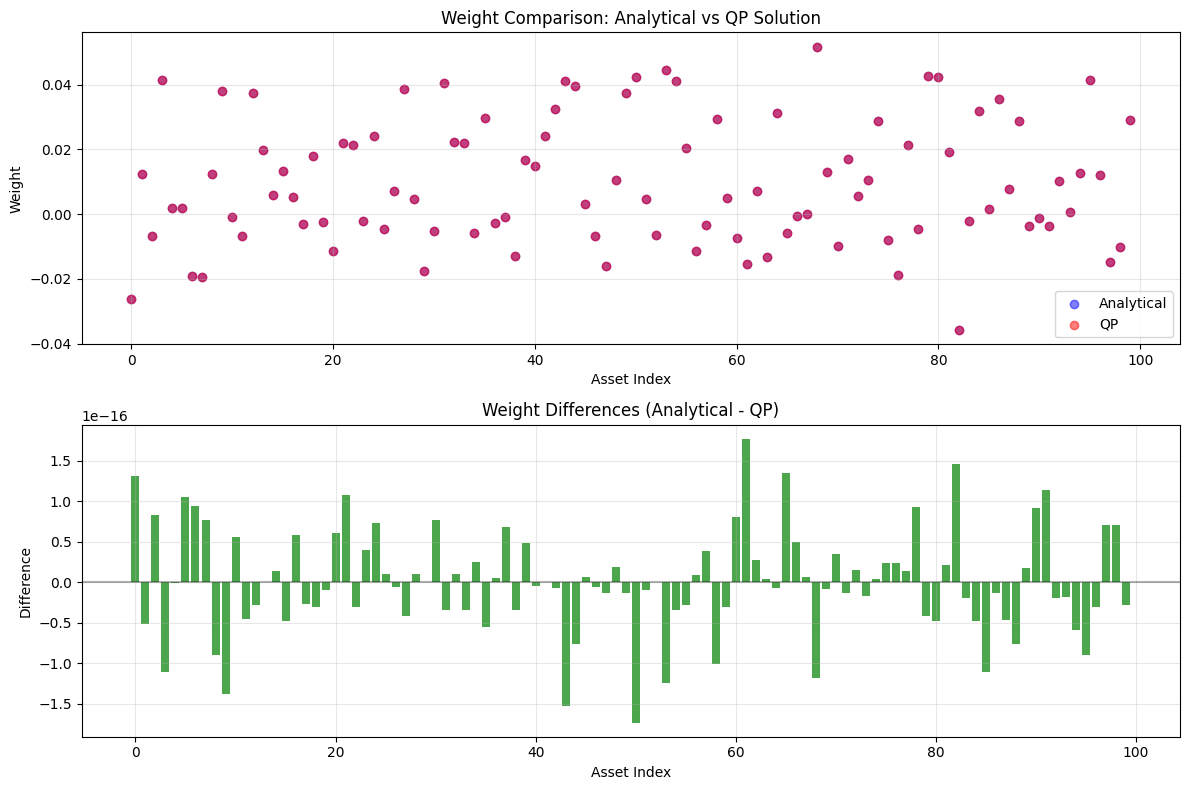


4. Portfolio variance comparison:
Analytical solution variance: 0.00034269
QP solution variance: 0.00034269
Relative difference: -0.00000000%


In [27]:
# 1. Define the MinVariance class
class MinVariance(Optimization):
    """
    MinVariance optimization class.
    
    This class implements minimum variance portfolio optimization.
    It supports both analytical solutions (for budget constraint only)
    and numerical solutions using the QP solver.
    """
    
    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        """Initialize the MinVariance class."""
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance
    
    def set_objective(self, optimization_data: OptimizationData) -> None:
        """
        Set the objective function for minimum variance.
        
        For minimum variance, we only use the covariance matrix.
        The objective is to minimize 1/2 * w^T * P * w, where q=0.
        """
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        
        # Set objective with zero expected returns (q=0)
        self.objective = Objective(
            P=covmat,  # Quadratic term (covariance matrix)
            q=np.zeros(len(X.columns))  # Linear term (zero for min variance)
        )
        return None
    
    def solve(self) -> None:
        """
        Solve the minimum variance optimization problem.
        
        If solver_name is 'analytical' and we only have a budget constraint,
        use the analytical solution. Otherwise, use the QP solver.
        """
        # Check if we should use analytical solution
        if self.params.get('solver_name') == 'analytical':
            # Check if only budget constraint is present
            has_only_budget = (
                self.constraints.budget['Amat'] is not None and  # Has budget constraint
                self.constraints.linear['G'] is None and         # No linear constraints
                self.constraints.box['box_type'] == 'NA'         # No box constraints
            )
            
            if has_only_budget:
                # Get covariance matrix
                cov_matrix = self.objective.coefficients['P'].to_numpy()
                
                # Calculate analytical solution
                # w = (Σ^-1 * 1) / (1^T * Σ^-1 * 1)
                ones = np.ones(cov_matrix.shape[0])
                
                # Calculate inverse of covariance matrix
                inv_cov = np.linalg.inv(cov_matrix)
                
                # Calculate weights
                numerator = inv_cov @ ones
                denominator = ones @ numerator
                weights = numerator / denominator
                
                # Store results
                self.results.update({
                    'weights': pd.Series(weights, index=self.constraints.ids).to_dict(),
                    'status': True
                })
                return None
        
        # If not using analytical solution or if it's not applicable,
        # use the standard QP solver
        return super().solve()

# 2. Create a constraints object with only a budget constraint
budget_constraints = Constraints(ids=df.columns.tolist())
budget_constraints.add_budget(rhs=1, sense='=')

# 3. Create the optimization data object
opt_data = OptimizationData(return_series=df)

# 4. Create and solve using analytical solution
print("1. Solving with analytical solution:")
analytical_optimizer = MinVariance(
    constraints=budget_constraints,
    covariance=cov_estimator,
    solver_name='analytical'  # Use analytical solver
)
analytical_optimizer.set_objective(opt_data)
analytical_optimizer.solve()

# Extract analytical solution weights
analytical_weights = pd.Series(analytical_optimizer.results['weights'])
print("Analytical solution - first 10 weights:")
print(analytical_weights.head(10))

# 5. Create and solve using QP solver
print("\n2. Solving with QP solver:")
qp_optimizer = MinVariance(
    constraints=budget_constraints,
    covariance=cov_estimator
    # Default solver will be used
)
qp_optimizer.set_objective(opt_data)
qp_optimizer.solve()

# Extract QP solution weights
qp_weights = pd.Series(qp_optimizer.results['weights'])
print("QP solution - first 10 weights:")
print(qp_weights.head(10))

# 6. Compare analytical and QP solutions
# Calculate differences
weight_diff = analytical_weights - qp_weights
print("\n3. Comparing solutions:")
print(f"Maximum absolute difference: {weight_diff.abs().max():.8f}")
print(f"Mean absolute difference: {weight_diff.abs().mean():.8f}")

# Visualize weight comparison
plt.figure(figsize=(12, 8))

# Plot weight comparison
plt.subplot(2, 1, 1)
plt.scatter(range(len(analytical_weights)), analytical_weights, 
           alpha=0.5, label='Analytical', color='blue')
plt.scatter(range(len(qp_weights)), qp_weights, 
           alpha=0.5, label='QP', color='red')
plt.title('Weight Comparison: Analytical vs QP Solution')
plt.xlabel('Asset Index')
plt.ylabel('Weight')
plt.legend()
plt.grid(alpha=0.3)

# Plot weight differences
plt.subplot(2, 1, 2)
plt.bar(range(len(weight_diff)), weight_diff, alpha=0.7, color='green')
plt.title('Weight Differences (Analytical - QP)')
plt.xlabel('Asset Index')
plt.ylabel('Difference')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Calculate and compare portfolio variances
port_var_analytical = analytical_weights @ P @ analytical_weights
port_var_qp = qp_weights @ P @ qp_weights

print("\n4. Portfolio variance comparison:")
print(f"Analytical solution variance: {port_var_analytical:.8f}")
print(f"QP solution variance: {port_var_qp:.8f}")
print(f"Relative difference: {((port_var_qp - port_var_analytical) / port_var_analytical):.8%}")

# 8. Compare with mean-variance solution from part 1.c
if 'best_weights' in locals():
    print("\n5. Comparing with mean-variance solution from part 1.c:")
    
    # Calculate mean-variance portfolio variance
    mv_var = best_weights @ P @ best_weights
    
    # Calculate mean-variance portfolio return
    mv_ret = best_weights @ q
    
    # Calculate minimum variance portfolio return
    min_var_ret = analytical_weights @ q
    
    print(f"Mean-Variance portfolio variance: {mv_var:.8f}")
    print(f"Mean-Variance portfolio return: {mv_ret:.8f}")
    print(f"Minimum Variance portfolio return: {min_var_ret:.8f}")
    print(f"Variance ratio (MV/Min-Var): {mv_var / port_var_analytical:.4f}")
    print(f"Return ratio (MV/Min-Var): {mv_ret / min_var_ret:.4f}")
    
    # Plot comparison of all portfolios
    plt.figure(figsize=(10, 6))
    
    # Create sorted indices for better visualization
    sorted_idx = np.argsort(analytical_weights.values)
    
    plt.plot(range(len(analytical_weights)), analytical_weights.values[sorted_idx], 
             'b-', label='Min Variance (Analytical)')
    plt.plot(range(len(qp_weights)), qp_weights.values[sorted_idx], 
             'r--', label='Min Variance (QP)')
    plt.plot(range(len(best_weights)), best_weights.values[sorted_idx], 
             'g-.', label=f'Mean-Variance ({best_solver})')
    
    plt.title('Portfolio Weight Comparison')
    plt.xlabel('Asset Index (sorted)')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot risk-return comparison
    plt.figure(figsize=(8, 6))
    plt.scatter([port_var_analytical], [min_var_ret], s=100, color='blue', 
               label='Min Variance (Analytical)')
    plt.scatter([port_var_qp], [min_var_ret], s=100, color='red', 
               label='Min Variance (QP)')
    plt.scatter([mv_var], [mv_ret], s=100, color='green', 
               label=f'Mean-Variance ({best_solver})')
    
    # Add labels
    for i, txt in enumerate([
        'Min Var (Analytical)', 
        'Min Var (QP)', 
        f'Mean-Var ({best_solver})'
    ]):
        x = [port_var_analytical, port_var_qp, mv_var][i]
        y = [min_var_ret, min_var_ret, mv_ret][i]
        plt.annotate(txt, (x, y), xytext=(10, 5), textcoords='offset points')
    
    plt.title('Risk-Return Comparison')
    plt.xlabel('Portfolio Variance (Risk)')
    plt.ylabel('Expected Return')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()